In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, classification_report

# 3.3 - Neural Network
The author used many machine learning models in their notebook, but they did not use any neural networks. In the following sections, we will show an implementation of a neural network, how the balance of the dataset affects the neural network, and then tune hyperparameters in an attempt to optimize the results.
<p> The neural network model we will be using is the MLPClassifier available via sci-kit learn. Our general procedure for training will be to scale the data, split into training and testing sets, and then train a MLP Classifier. In later sections, we will use GridSearchCV for hyperparameter tuning and cross-validation.

# 3.3.1 - Training a simple neural network
The author created a balanced dataset for their notebook; however, we would like to first see how a neural network performs on the original, imbalanced dataset. Neural Networks, just like the other machine learning models the author used, are adversely affected by imbalanced training data.

In [ ]:
#read the imbalanced data set, df3
df3 = pd.read_csv('https://raw.githubusercontent.com/jnarlyv/csvstorage/main/diabetes_binary_health_indicators_BRFSS2015.csv')
#Features and labels
X_imb, y_imb = df3.iloc[:, 1:].values, df3.iloc[:, 0].values
#Scaling and splitting
mms = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X_imb, y_imb, test_size=0.3,
                     stratify=y_imb, random_state=0)
X_train_mms = mms.fit_transform(X_train)
X_test_mms = mms.transform(X_test)
#Train neural network
mlp_imbalanced = MLPClassifier(max_iter=10000, random_state=0,
                               hidden_layer_sizes = (12,12), activation='relu')
#Fit
mlp_imbalanced.fit(X_train, y_train)
#Predict
predictions = mlp_imbalanced.predict(X_test)
#Results
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93     65500
         1.0       0.61      0.14      0.22     10604

    accuracy                           0.87     76104
   macro avg       0.74      0.56      0.58     76104
weighted avg       0.84      0.87      0.83     76104



Especially in the context of medicine, recall is an important measure of how well the model is performing. For example, if our goal was to train a model that catches as many cases of diabetes as possible, then we would want the recall for diabetes (label = 1) to be high. The table above, created via classification_report provided by sci-kit learn, shows the recall for diabetes is 14%. That is quite low. This means our model is failing to predict 86% of the cases where the person has diabetes. In the upcoming sections, we will see how the recall changes based on the balance of the dataset and the tuning of hyperparameters.

To give even more insight into how the model is performing, lets think about the accuracy that would be achieved by guessing. Since non-diabetic (label = 0) records are the most common, we can use that as our guess each time. On this testing dataset using that guessing strategy, we would have 65500 correct out of 76104 = 86.06% accuracy. The neural network achieved 87% accuracy. Keeping this baseline in mind, we will see how the accuracy changes when a balanced dataset is used for training.

# 3.3.2 - Creating a balanced training dataset

In this section, we will first implement two methods to aid in balancing the training dataset. The first method shuffles the original dataframe. The second method takes a specified number of records and extracts that many from the original dataset per the specified ratio. When undersampling data, it is not necessary to make the new distribution completely equal. Here, we make the distribution less imbalanced than before by selecting training data in a 1:4 (diabetic:non-diabetic) ratio.

In [ ]:
def shuffle_and_reset(df):
  """ Takes in a dataframe and return a new dataframe where the
  data has been shuffled and indices reset """
  dataframe = df.copy()
  # Shuffle the DataFrame rows
  dataframe = dataframe.sample(frac=1, random_state=1).reset_index(drop=True)
  return dataframe

def balance_data(df,ratio,total_records=45000,label='Diabetes_binary'):
  """ Creates a balanced training set, and returns rest of the records
  in a separate dataframe """
  df_0_sampled = df[df[label] == 0].sample(n=int((1-ratio)*total_records),
                                           random_state=1)
  df_1_sampled = df[df[label] == 1].sample(n=int(ratio*total_records),
                                           random_state=1)
  df_balanced = pd.concat([df_0_sampled, df_1_sampled])
  balanced_indices = df_balanced.index
  remaining_df = df.drop(index=balanced_indices)
  df_bal = shuffle_and_reset(df_balanced)
  df_unbal = shuffle_and_reset(remaining_df)
  return df_bal, df_unbal

training, test = balance_data(df=df3, ratio=.2)

In [ ]:
#Scaling and splitting
X_train, y_train = training.iloc[:, 1:].values, training.iloc[:, 0].values
X_test, y_test = test.iloc[:, 1:].values, test.iloc[:, 0].values
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)
#Train neural network
mlp = MLPClassifier(max_iter=100000, random_state=0,
                               hidden_layer_sizes = (12,12), activation='relu')
#Fit
mlp.fit(X_train, y_train)
#Predict
predictions = mlp.predict(X_test)
#Results
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.93    182334
         1.0       0.47      0.29      0.36     26346

    accuracy                           0.87    208680
   macro avg       0.69      0.62      0.64    208680
weighted avg       0.85      0.87      0.86    208680



We have managed to keep the accuracy the same while substantially increasing the recall for the diabetic label.

# 3.3.3 - Hyperparameter tuning with GridSearchCV


In this section, we use both the raw dataset and a more balanced dataset along with GridSearchCV to tune the following hyperparameters of our neural network:

*   Type of scaling: MinMax vs. Standard
*   Number of hidden layers: 1,3,4
*   Number of neurons: 11,25,100
*   Activation function: Logistic vs. ReLu
*   Initial learning rates: 0.0001, 0.00001

We will be examining both the recall and the accuracy of the GridSearchCV results when using the balanced vs. raw dataset. Our analysis of the results for both cases is located at the end of this section.

A note on accuracy and recall: In the balanced dataset, the ratio between diabetes:non-diabetes classes is 1:4. With guessing label = diabetes each time, we would expect to achieve 80% accuracy and 0% recall (for label 1) on this data set. For the raw dataset, the distribution is closer to 1:7.


# 3.3.3.1 - Hyperparameter tuning on the balanced dataset

In [ ]:
balanced, dnu = balance_data(df=df3, ratio=.2, total_records=175000)
X, y = balanced.iloc[:, 1:].values, balanced.iloc[:, 0].values
#Create the grid
GRID = [
    {'scaler': [MinMaxScaler(),StandardScaler()],
     'estimator': [MLPClassifier(random_state=0)],
     'estimator__solver': ['adam'],
     'estimator__learning_rate_init': [0.0001, 0.00001],
     'estimator__max_iter': [10000],
     'estimator__hidden_layer_sizes': [(11),(10,5,10),(33,17,17,33)],
     'estimator__activation': ['logistic', 'relu'],
     'estimator__alpha': [0.0001],
     }
]
#Define scores
scoring = {'Accuracy': make_scorer(accuracy_score), 'Recall': make_scorer(recall_score)}
PIPELINE = Pipeline([('scaler', None), ('estimator', MLPClassifier())])
grid_search = GridSearchCV(estimator=PIPELINE, param_grid=GRID,
                            scoring=scoring,
                            n_jobs=-1, refit='Accuracy', verbose=1,
                            return_train_score=False)

grid_search.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', None),
                                       ('estimator', MLPClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator': [MLPClassifier(activation='logistic',
                                                      hidden_layer_sizes=(33,
                                                                          17,
                                                                          17,
                                                                          33),
                                                      learning_rate_init=0.0001,
                                                      max_iter=10000,
                                                      random_state=0)],
                          'estimator__activation': ['logistic', 'relu'],
                          'estimator__alpha': [0.0001],
                          'estimator__hidden_layer_sizes': [11, (10, 5, 10),
                                                            (33, 17, 17, 33)],
                          'estimator__learning_rate_init': [0.0001, 1e-05],
                          'estimator__max_iter': [10000],
                          'estimator__solver': ['adam'],
                          'scaler': [MinMaxScaler(), StandardScaler()]}],
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'Recall': make_scorer(recall_score)},
             verbose=1)

In [ ]:
#Format results
df_results = pd.concat(
    [pd.DataFrame(grid_search.cv_results_["params"]),
     pd.DataFrame(grid_search.cv_results_["mean_test_Accuracy"], columns=["Accuracy"]),
     pd.DataFrame(grid_search.cv_results_["mean_test_Recall"], columns=["Recall"])],axis=1)

df_results = df_results.sort_values(by="Recall", ascending=False)
df_results = df_results.drop(columns=['estimator__max_iter'])
df_results = df_results.drop(columns=['estimator__solver'])
df_results = df_results.drop(columns=['estimator__alpha'])
df_results = df_results.drop(columns=['estimator'])
df_results

,estimator__activation,estimator__hidden_layer_sizes,estimator__learning_rate_init,scaler,Accuracy,Recall
9,logistic,"(33, 17, 17, 33)",0.00010,StandardScaler(),0.820983,0.324886
1,logistic,11,0.00010,StandardScaler(),0.820417,0.322229
20,relu,"(33, 17, 17, 33)",0.00010,MinMaxScaler(),0.820257,0.316943
5,logistic,"(10, 5, 10)",0.00010,StandardScaler(),0.820560,0.314429
21,relu,"(33, 17, 17, 33)",0.00010,StandardScaler(),0.820840,0.310771
15,relu,11,0.00001,StandardScaler(),0.817080,0.309143
13,relu,11,0.00010,StandardScaler(),0.819354,0.307857
8,logistic,"(33, 17, 17, 33)",0.00010,MinMaxScaler(),0.816606,0.299714
17,relu,"(10, 5, 10)",0.00010,StandardScaler(),0.820451,0.299629
23,relu,"(33, 17, 17, 33)",0.00001,StandardScaler(),0.817457,0.299343


In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])
print("Best recall found: ", grid_search.cv_results_['mean_test_Recall'][grid_search.best_index_])

Best parameters found:  {'estimator': MLPClassifier(activation='logistic', hidden_layer_sizes=(33, 17, 17, 33),
              learning_rate_init=0.0001, max_iter=10000, random_state=0), 'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (33, 17, 17, 33), 'estimator__learning_rate_init': 0.0001, 'estimator__max_iter': 10000, 'estimator__solver': 'adam', 'scaler': StandardScaler()}
Best accuracy found:  0.8209828571428572
Best recall found:  0.3248857142857143


# 3.3.3.2 - Hyperparameter tuning on the raw dataset

In [5]:
X, y = df3.iloc[:, 1:].values, df3.iloc[:, 0].values
GRID = [
    {'scaler': [MinMaxScaler(),StandardScaler()],
     'estimator': [MLPClassifier(random_state=0)],
     'estimator__solver': ['adam'],
     'estimator__learning_rate_init': [0.0001, 0.00001],
     'estimator__max_iter': [10000],
     'estimator__hidden_layer_sizes': [(11),(10,5,10),(33,17,17,33)],
     'estimator__activation': ['logistic', 'relu'],
     'estimator__alpha': [0.0001],
     }
]
scoring = {'Accuracy': make_scorer(accuracy_score), 'Recall': make_scorer(recall_score)}
PIPELINE = Pipeline([('scaler', None), ('estimator', MLPClassifier())])
grid_search = GridSearchCV(estimator=PIPELINE, param_grid=GRID,
                            scoring=scoring,
                            n_jobs=-1, refit='Accuracy', verbose=1,
                            return_train_score=False)

grid_search.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', None),
                                       ('estimator', MLPClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator': [MLPClassifier(activation='logistic',
                                                      hidden_layer_sizes=(33,
                                                                          17,
                                                                          17,
                                                                          33),
                                                      learning_rate_init=0.0001,
                                                      max_iter=10000,
                                                      random_state=0)],
                          'estimator__activation': ['logistic', 'relu'],
                          'estimator__alpha': [0.0001],
                          'estimator__hidden_layer_sizes': [11, (10, 5, 10),
                                                            (33, 17, 17, 33)],
                          'estimator__learning_rate_init': [0.0001, 1e-05],
                          'estimator__max_iter': [10000],
                          'estimator__solver': ['adam'],
                          'scaler': [MinMaxScaler(), StandardScaler()]}],
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'Recall': make_scorer(recall_score)},
             verbose=1)

In [6]:
df_results = pd.concat(
    [pd.DataFrame(grid_search.cv_results_["params"]),
     pd.DataFrame(grid_search.cv_results_["mean_test_Accuracy"], columns=["Accuracy"]),
     pd.DataFrame(grid_search.cv_results_["mean_test_Recall"], columns=["Recall"])],axis=1)

df_results = df_results.sort_values(by="Recall", ascending=False)
df_results = df_results.drop(columns=['estimator__max_iter'])
df_results = df_results.drop(columns=['estimator__solver'])
df_results = df_results.drop(columns=['estimator__alpha'])
df_results = df_results.drop(columns=['estimator'])
df_results

,estimator__activation,estimator__hidden_layer_sizes,estimator__learning_rate_init,scaler,Accuracy,Recall
21,relu,"(33, 17, 17, 33)",0.00010,StandardScaler(),0.866123,0.156906
20,relu,"(33, 17, 17, 33)",0.00010,MinMaxScaler(),0.865807,0.155605
17,relu,"(10, 5, 10)",0.00010,StandardScaler(),0.865638,0.150964
13,relu,11,0.00010,StandardScaler(),0.865516,0.145108
15,relu,11,0.00001,StandardScaler(),0.863517,0.144260
9,logistic,"(33, 17, 17, 33)",0.00010,StandardScaler(),0.866418,0.142195
1,logistic,11,0.00010,StandardScaler(),0.865839,0.131698
12,relu,11,0.00010,MinMaxScaler(),0.864928,0.126493
16,relu,"(10, 5, 10)",0.00010,MinMaxScaler(),0.863951,0.123635
23,relu,"(33, 17, 17, 33)",0.00001,StandardScaler(),0.863923,0.113790


In [7]:
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_])
print("Best recall found: ", grid_search.cv_results_['mean_test_Recall'][grid_search.best_index_])

Best parameters found:  {'estimator': MLPClassifier(activation='logistic', hidden_layer_sizes=(33, 17, 17, 33),
              learning_rate_init=0.0001, max_iter=10000, random_state=0), 'estimator__activation': 'logistic', 'estimator__alpha': 0.0001, 'estimator__hidden_layer_sizes': (33, 17, 17, 33), 'estimator__learning_rate_init': 0.0001, 'estimator__max_iter': 10000, 'estimator__solver': 'adam', 'scaler': StandardScaler()}
Best accuracy found:  0.8664183222958058
Best recall found:  0.1421946250967679


# 3.3.3.3 - Findings for both tunings

**Balanced dataset**
<p>The best recall = 32.49% and the best accuracy = 82.10% belong to the estimator with these parameters:

*   Activation = logistic
*   Hidden layer sizes = (33, 17, 17, 33)
*   Initial learning rate = 0.0001
*   Scaler = StandardScaler()


Some interesting findings from the GridSearchCV results table:

*   StandardScaler() typically performed better than MinMaxScaler()
*   For a given network architecture, the difference between accuracy for logistic and relu activation functions is minimal, but recall rate can vary. Example: Compare item 9 to item 21 below:<p>
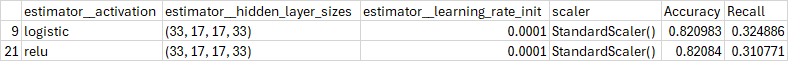
*   The larger initial learning rate consistently performed better than the smaller rate. This could be due to the algorithm getting "stuck" in a local minima when too small an initial learning rate is used.
*   The logistic activation function seems vulnerable to falling into the "trap" of guessing the majority class. This is shown in the last 3 rows of the table. The ReLu activation function did not exhibit this behavior for this data.<p>
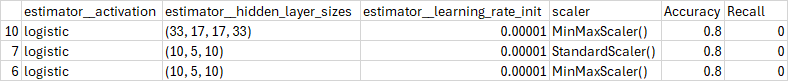

**Raw dataset**
<p>The best recall = 14.22% and the best accuracy = 86.64% belong to the same estimator parameters as the balanced dataset except for the activation function:



*   Activation = relu
*   Hidden layer sizes = (33, 17, 17, 33)
*   Initial learning rate = 0.0001
*   Scaler = StandardScaler()

Some interesting findings from the GridSearchCV results table:


*   The combination of logistic activation + lower initial learning rate once again led to the "trap" of guessing the majority class. The accuracy for all estimators using these two parameters was 86.07% (the baseline level accuracy) and 0% recall.<p>
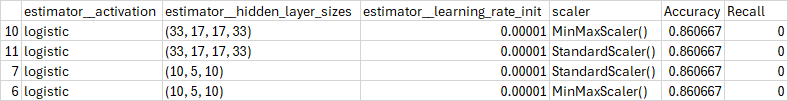
*   The range of differences in accuracy between all combinations of parameters is much smaller than the balanced dataset.



# 3.3.4 - Conclusion
For our neural network training on the diabetes dataset, we improved the recall by decreasing the disparity between the majority and minority classes. In raw percentages, the accuracy for the balanced dataset was lower, but when compared to the baseline accuracy (80%) it was actually an improvement. While the MLPClassifier is a neural network model, it does not offer in-depth customization such as layer-specific activation functions. We are interested in using more custom and advanced neural network architectures available within PyTorch to discover if better recall performance is possible on this dataset.